# Distribution of vegetation in a landscape of heterogeneous predation risk

In [15]:
# importing libraries

import numpy as np
from matplotlib import pyplot as plt
import math
from itertools import permutations as perm

# Notebook parameters

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 20

## Defining initialisation functions

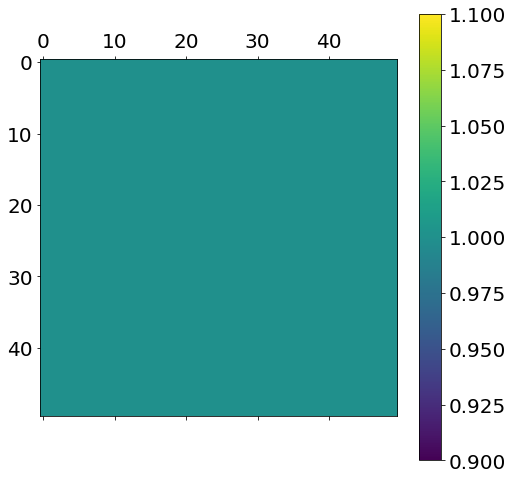

In [16]:
# Defining resource matrix

def veg(N):
    
    # Starting with resoource available everywhere
    
    V = np.full((N, N), 1)

    return V

# test plot

plt.matshow(veg(50))
plt.colorbar()

In [17]:
# Creating list of fish in the landscape

def fish_vec(n, N):

    # n = initial number of fish
    # N = size of the landscape

    # Iniital position at the center

    x = int(N/2); y = int(N/2)

    # Data for a single fish

    fish = np.array([(x,y), 0], # [(position), starvation time]
    dtype='object')

    fish_pop = np.full((n,2), fish, dtype='object')

    return fish_pop

# test

print(fish_vec(5, 50))

[[(25, 25) 0]
 [(25, 25) 0]
 [(25, 25) 0]
 [(25, 25) 0]
 [(25, 25) 0]]


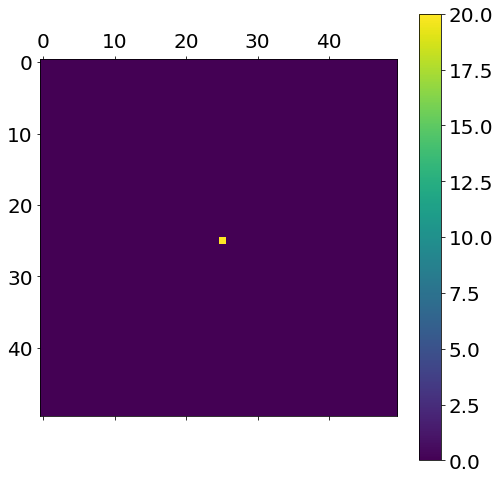

In [18]:
# summarising fish density in the landscape

def fish_mat(fish_pop, N):

    # creating an empty matrix for fish

    F =  np.zeros((N, N))

    # Extracting fish positioins

    fish_pos = fish_pop[:,0]

    # Summing number of fish in each cell

    for index, value in np.ndenumerate(F):

        for f in fish_pos:

            if index == f:

                F[index] += 1

    return F

# test

fish_pop = fish_vec(20, 50)

plt.matshow(fish_mat(fish_pop, 50))
plt.colorbar()

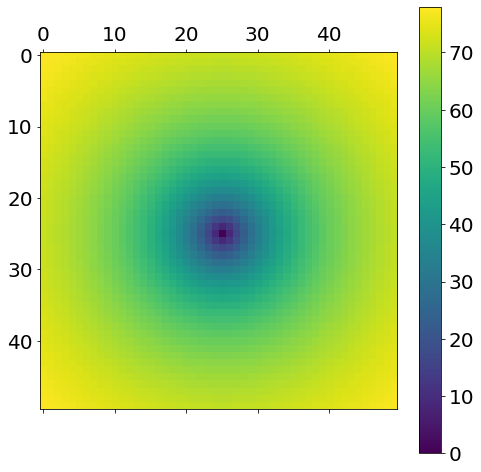

In [19]:
# Defining predation risk maatrix

def risk(N):

    # defining a N x N matrix

    R =  np.zeros((N, N))

    # Creating a gradient of predation risk

    c = N/2 # center of the array

    for index, value in np.ndenumerate(R):

        # Calculating distinace from the center
    
        dist =  math.sqrt((c - index[0])**2 + (c - index[1])**2)

        # Asymptotic increase of predation risk from center 

        value = (dist/(10 + dist))*100

        # updating value
    
        R[index] = value

    return R

# test plot

plt.matshow(risk(50))
plt.colorbar()

## Defining update functions

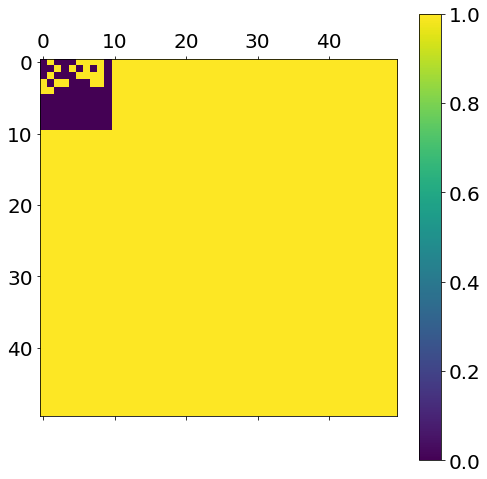

In [20]:
# spread and regeneration of vegetation

def veg_update(veg_mat):

    N = np.shape(veg_mat) # getting shape of vegetation matrix

    for index, value in np.ndenumerate(veg_mat):

        if value == 0:

            adj = [] # empty list of adjascent cells

            # getting list of adjascent cells

            for dx in [-1, 0, 1]:

                for dy  in [-1, 0, 1]:

                    x = index[0] + dx # horizontal

                    y = index[1] + dy # vertical

                    # Periodic boundaries

                    if x > N[0]-1 and y > N[1]-1:

                         x = x - N[0] - 1

                         y = y - N[1] - 1
                         
                         adj.append((x,y))

                    elif x > N[0]-1 or y > N[1]-1:

                        if x > N[0]-1:

                            x = x - N[0] - 1

                            adj.append((x, y))
                        
                        else:

                            y = y - N[1] - 1

                            adj.append((x, y))

                    else:
                
                        adj.append((x, y))

            # Spread of vegetation

            ## Getting values from adjascent cells

            adj_veg = []

            for cell in adj:

                adj_veg.append(veg_mat[cell])
            
            ## checking if neighbours are present

            if all(x == 0 for x in adj_veg):

                break
            
            else:
                
                # updating value 

                veg_mat[index] = int(np.random.choice(a = [0,1], p =  [0.5, 0.5])) # p = 0.5

    return(veg_mat)

# Test

V = veg(50)

for dx in range(10):

    for dy in range(10):

        V[dx, dy] = 0

V = veg_update(V)

plt.matshow(V)
plt.colorbar()


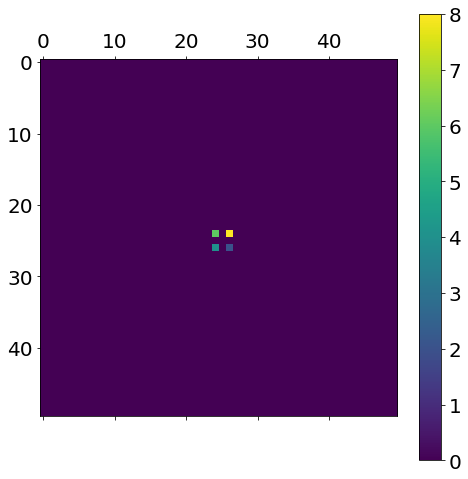

In [21]:
# updating fish positions

def fish_mov(fish_pop):

    index = 0

    for f in fish_pop:

        # 2 - D unbiased random walk

        dx = f[0][0] + np.random.choice(a = [-1,1], p = [0.5, 0.5])
        dy = f[0][1] + np.random.choice(a = [-1,1], p = [0.5, 0.5])

        # Periodic boundaries

        if dx >= 49:

            dx = abs(dx) - 49

            if dy >= 49:

                dy = abs(dy) - 49
    
        elif dy >= 49:

            dy = abs(dy) - 49

        fish_pop[index][0] = (dx, dy)

        index += 1

    return fish_pop

# Test

fish_pop = fish_vec(20, 50)

fish_t1 = fish_mov(fish_pop)

plt.matshow(fish_mat(fish_t1, 50))
plt.colorbar()

In [22]:
# Fish reproduction

def fish_rep(fish_pop):

    for f in fish_pop:

        rep = np.random.choice(a = [0,1], p = [0.99, 0.01]) # P(reproduce) = 0.01

        if rep == 1:

            f[1] = 0 #resetting starvation clock

            fish_pop = np.append(fish_pop, [f], axis = 0)
    
    return fish_pop


# Test

fish_pop = fish_vec(20, 50)

print(len(fish_rep(fish_pop)))

20


In [23]:
# Fish starvation

def fish_starve(fish_pop):
    
    index = 0

    idx = []

    for f in fish_pop:

        # At t_S = 10, fish dies

        if f[1] == 10:

            idx.append(index)
        
        else:

            # Starvation clock increases with each time step

            fish_pop[index, 1] = fish_pop[index, 1] + 1

        index += 1
    
    # Killing fish

    fish_pop = np.delete(fish_pop, idx, axis = 0)

    return fish_pop

# Test

fish_pop = fish_vec(20, 50)

for t in range(12):

    fish_pop = fish_starve(fish_pop)

    print(len(fish_pop))


20
20
20
20
20
20
20
20
20
20
0
0


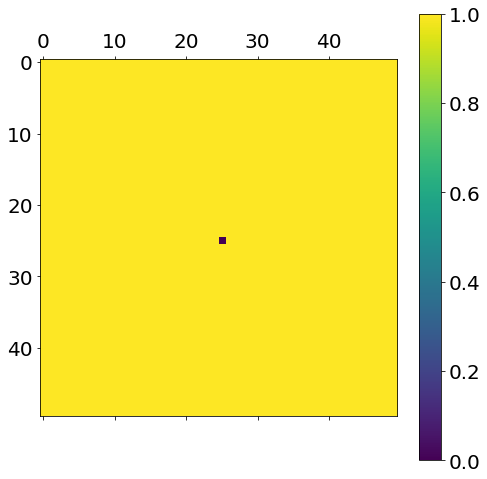

In [24]:
# Fish feeding

def fish_feed(fish_pop, veg_mat):

    index = 0

    for f in fish_pop:

        # Check if vegetation is present

        if veg_mat[f[0]] == 1:

            # Fish eats the vegetations 

            # Veg disappears

            veg_mat[f[0]] = 0

            # Fish starvation clock starts over

            fish_pop[index, 1] = 0
        
        index += 1
    
    return veg_mat, fish_pop

# Test

fish_pop = fish_vec(20, 50)

veg_mat = veg(50)

veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

plt.matshow(veg_mat)
plt.colorbar()


## Simulating 

In [25]:
# Defining simulation parameters

T_max = 1000 # time for the simulation
N = 50 # length of side for N x N matrix
n = 1000 # initial number of fish

In [26]:
# Initialising the landscape

fish_pop = fish_vec(n, N) # fish population
veg_mat = veg(N) # resource matrix
alpha = risk(N) # risk matrix


In [27]:
fish_abn = [0]*T_max # fish abundance
veg_abn = [0]*T_max # resource abundance

for t in range(T_max):

    # Updating resource values

    veg_mat = veg_update(veg_mat)

    # Fish feeding

    veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

    # Fish starvation and death

    fish_pop = fish_starve(fish_pop)

    # Fish reproduce

    fish_pop = fish_rep(fish_pop)

    # Fish movement

    fish_pop = fish_mov(fish_pop)

    # Logging fish abundance

    fish_abn[t] = len(fish_pop)

    # Logging resource

    veg_abn[t] = np.sum(veg_mat)



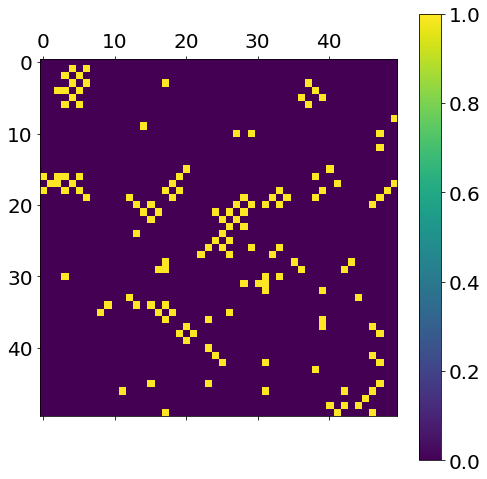

In [28]:
plt.matshow(veg_mat)
plt.colorbar()

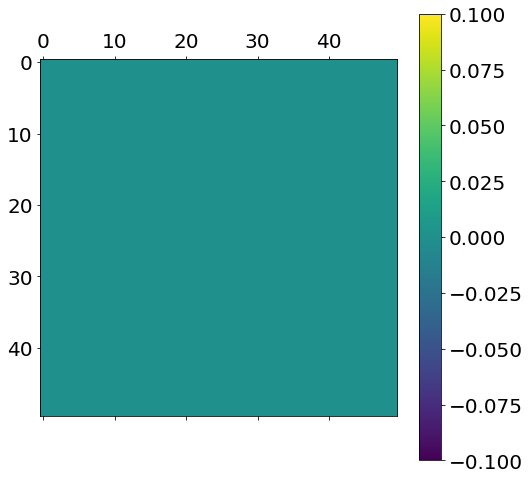

In [32]:
plt.matshow(fish_mat(fish_pop, N))
plt.colorbar()

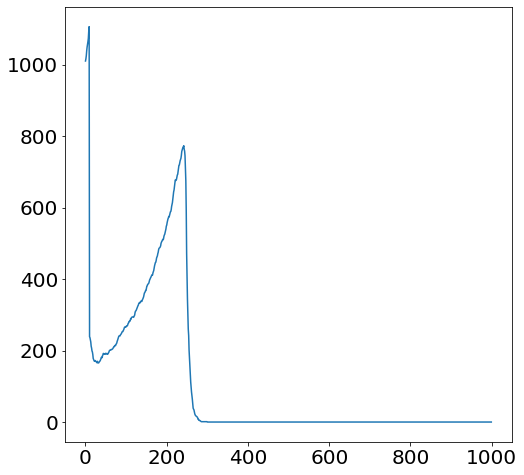

In [33]:
plt.plot(range(T_max), fish_abn)

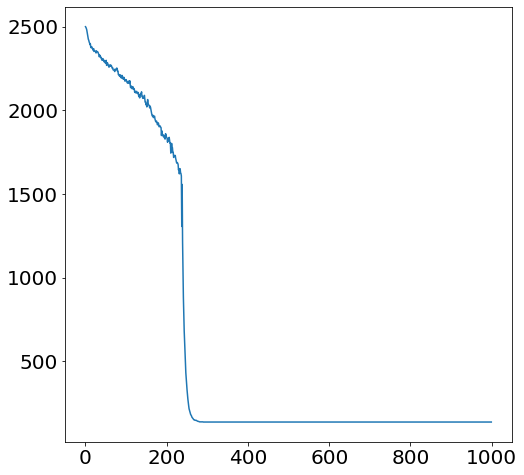

In [34]:
plt.plot(range(T_max), veg_abn)